In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import japanize_matplotlib
from IPython.display import display

# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [3]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
df = pd.read_csv('n1c1o.csv')
df2 = pd.read_csv('n1c1p.csv')
df3 = pd.read_csv('n1c3o.csv')
df4 = pd.read_csv('n3c1o.csv')

In [5]:
phi = np.array( df.columns).astype(float)
phi2 = np.array( df2.columns).astype(float)
phi3 = np.array( df3.columns).astype(float)
phi4 = np.array( df4.columns).astype(float)

In [6]:
x = np.array(df).astype(complex)
x2 = np.array(df2).astype(complex)
x3 = np.array(df3).astype(complex)
x4 = np.array(df4).astype(complex)

In [7]:
#absでいい？absにしなくてもerrorはでないと思う　
x = np.abs( x )
x2 = np.abs(x2)
x3 = np.abs(x3)
x4 = np.abs(x4)

In [8]:
#ひとつにまとめる
x_data = np.vstack([x, x2, x3, x4])
y_data = np.hstack([np.array( [0]* 800 ),
                    np.array( [1]* 800 ),
                    np.array( [2]* 800 ),
                    np.array( [3]* 800 )
                   ])
# train setと検証 set に分割
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2400, 20000) (800, 20000) (2400,) (800,)


In [9]:
# モデルの引数と入力が同じ型でないとエラーが出るためいたるところにfloat()とlong()があるがこんなになくてもいい
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device).float()
    labels = labels.to(device).long()

    # 予測計算
    outputs = net(inputs.float())

    #  損失計算
    loss = criterion(outputs.float(), labels.long())

    return loss

In [10]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            net = net.float()
            outputs = net(inputs.float()).float()
            
            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [11]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure()
    plt.plot(history[:,0], history[:,1], c = 'r', label='train')
    plt.plot(history[:,0], history[:,3],  c = 'c', label='validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('number epoch')
    plt.ylabel('loss')
    plt.title('Learning Curve(loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure()
    plt.plot(history[:,0], history[:,2], 'r', label='train')
    plt.plot(history[:,0], history[:,4], c = 'c', label='validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('number epoch')
    plt.ylabel('accuracy')
    plt.title('Learning Curve(accuracy)')
    plt.legend()
    plt.show()

In [12]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [13]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 50

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

In [14]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)

torch.Size([50, 20000])


In [15]:
#n_input = image1.view(-1).shape[0]
n_input = images1[0].shape
# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels1.data.numpy())))

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: torch.Size([20000])  n_hidden: 128 n_output: 4


In [16]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.relu = nn.ReLU(inplace=True)
    self.l1 = nn.Linear(20000, 1024)
    self.l2 = nn.Linear(1024, n_output)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x = self.classifier(x)
    return x       

In [17]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [18]:
# モデルの概要表示
print(net)

CNN(
  (relu): ReLU(inplace=True)
  (l1): Linear(in_features=20000, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=4, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=4, bias=True)
  )
)


In [19]:
# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

In [20]:
%%time
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.02277 acc: 0.49042 val_loss: 0.02078, val_acc: 0.50208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.01991 acc: 0.56333 val_loss: 0.01906, val_acc: 0.66833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.01833 acc: 0.77333 val_loss: 0.01756, val_acc: 0.84375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.01686 acc: 0.88167 val_loss: 0.01611, val_acc: 0.91667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.01542 acc: 0.94042 val_loss: 0.01470, val_acc: 0.94708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.01405 acc: 0.95583 val_loss: 0.01337, val_acc: 0.96833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.01277 acc: 0.97667 val_loss: 0.01215, val_acc: 0.98083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.01160 acc: 0.98375 val_loss: 0.01104, val_acc: 0.98583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.01056 acc: 0.98583 val_loss: 0.01005, val_acc: 0.98292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.00962 acc: 0.98083 val_loss: 0.00916, val_acc: 0.97792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.00878 acc: 0.97750 val_loss: 0.00837, val_acc: 0.97542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.00803 acc: 0.97417 val_loss: 0.00767, val_acc: 0.97417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.00736 acc: 0.97333 val_loss: 0.00704, val_acc: 0.97375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.00677 acc: 0.97292 val_loss: 0.00649, val_acc: 0.97292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.00624 acc: 0.97375 val_loss: 0.00599, val_acc: 0.97292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.00578 acc: 0.97333 val_loss: 0.00555, val_acc: 0.97375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.00536 acc: 0.97292 val_loss: 0.00516, val_acc: 0.97417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.00500 acc: 0.97417 val_loss: 0.00481, val_acc: 0.97500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.00467 acc: 0.97625 val_loss: 0.00450, val_acc: 0.97500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.00436 acc: 0.97625 val_loss: 0.00423, val_acc: 0.97708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.00411 acc: 0.97542 val_loss: 0.00398, val_acc: 0.97750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.00387 acc: 0.97875 val_loss: 0.00375, val_acc: 0.97875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.00365 acc: 0.97792 val_loss: 0.00354, val_acc: 0.98083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.00346 acc: 0.98083 val_loss: 0.00336, val_acc: 0.98083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.00328 acc: 0.97958 val_loss: 0.00319, val_acc: 0.98125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.00312 acc: 0.98208 val_loss: 0.00304, val_acc: 0.98125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.00298 acc: 0.98125 val_loss: 0.00290, val_acc: 0.98125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.00284 acc: 0.98208 val_loss: 0.00277, val_acc: 0.98208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.00272 acc: 0.98167 val_loss: 0.00265, val_acc: 0.98167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.00260 acc: 0.98208 val_loss: 0.00254, val_acc: 0.98417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.00251 acc: 0.98417 val_loss: 0.00245, val_acc: 0.98417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.00241 acc: 0.98458 val_loss: 0.00235, val_acc: 0.98458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.00232 acc: 0.98583 val_loss: 0.00226, val_acc: 0.98625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.00223 acc: 0.98625 val_loss: 0.00218, val_acc: 0.98708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.00216 acc: 0.98833 val_loss: 0.00211, val_acc: 0.98667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.00209 acc: 0.98625 val_loss: 0.00204, val_acc: 0.98708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.00201 acc: 0.98750 val_loss: 0.00199, val_acc: 0.98750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.00196 acc: 0.98833 val_loss: 0.00191, val_acc: 0.99000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.00189 acc: 0.98958 val_loss: 0.00186, val_acc: 0.99000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.00184 acc: 0.99083 val_loss: 0.00180, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.00179 acc: 0.99083 val_loss: 0.00175, val_acc: 0.99083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.00174 acc: 0.99042 val_loss: 0.00170, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.00169 acc: 0.99208 val_loss: 0.00165, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.00164 acc: 0.99083 val_loss: 0.00161, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.00160 acc: 0.99208 val_loss: 0.00157, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.00156 acc: 0.99167 val_loss: 0.00154, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.00152 acc: 0.99167 val_loss: 0.00149, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.00148 acc: 0.99208 val_loss: 0.00146, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.00145 acc: 0.99208 val_loss: 0.00142, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.00141 acc: 0.99167 val_loss: 0.00140, val_acc: 0.99167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.00138 acc: 0.99250 val_loss: 0.00136, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.00135 acc: 0.99125 val_loss: 0.00133, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.00133 acc: 0.99250 val_loss: 0.00130, val_acc: 0.99250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.00129 acc: 0.99292 val_loss: 0.00128, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.00127 acc: 0.99208 val_loss: 0.00125, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.00125 acc: 0.99250 val_loss: 0.00123, val_acc: 0.99333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.00122 acc: 0.99333 val_loss: 0.00120, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.00120 acc: 0.99292 val_loss: 0.00118, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.00117 acc: 0.99292 val_loss: 0.00115, val_acc: 0.99333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.00115 acc: 0.99292 val_loss: 0.00113, val_acc: 0.99375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.00113 acc: 0.99375 val_loss: 0.00111, val_acc: 0.99375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.00111 acc: 0.99333 val_loss: 0.00109, val_acc: 0.99417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.00109 acc: 0.99417 val_loss: 0.00108, val_acc: 0.99500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.00107 acc: 0.99417 val_loss: 0.00105, val_acc: 0.99500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.00105 acc: 0.99417 val_loss: 0.00103, val_acc: 0.99458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.00103 acc: 0.99500 val_loss: 0.00102, val_acc: 0.99500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.00101 acc: 0.99458 val_loss: 0.00100, val_acc: 0.99542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.00100 acc: 0.99458 val_loss: 0.00098, val_acc: 0.99583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.00098 acc: 0.99542 val_loss: 0.00097, val_acc: 0.99583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.00096 acc: 0.99583 val_loss: 0.00096, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.00095 acc: 0.99583 val_loss: 0.00094, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.00094 acc: 0.99583 val_loss: 0.00092, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.00092 acc: 0.99625 val_loss: 0.00091, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.00091 acc: 0.99708 val_loss: 0.00090, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.00090 acc: 0.99667 val_loss: 0.00088, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.00088 acc: 0.99667 val_loss: 0.00087, val_acc: 0.99625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.00087 acc: 0.99625 val_loss: 0.00086, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.00086 acc: 0.99708 val_loss: 0.00085, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.00085 acc: 0.99708 val_loss: 0.00083, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.00083 acc: 0.99750 val_loss: 0.00082, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.00082 acc: 0.99708 val_loss: 0.00081, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.00081 acc: 0.99708 val_loss: 0.00080, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.00080 acc: 0.99750 val_loss: 0.00079, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.00079 acc: 0.99750 val_loss: 0.00078, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.00078 acc: 0.99708 val_loss: 0.00077, val_acc: 0.99792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.00077 acc: 0.99750 val_loss: 0.00076, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.00076 acc: 0.99792 val_loss: 0.00075, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.00075 acc: 0.99792 val_loss: 0.00074, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.00074 acc: 0.99833 val_loss: 0.00073, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.00073 acc: 0.99833 val_loss: 0.00073, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.00072 acc: 0.99833 val_loss: 0.00071, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.00071 acc: 0.99833 val_loss: 0.00071, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.00071 acc: 0.99833 val_loss: 0.00070, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.00070 acc: 0.99833 val_loss: 0.00069, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.00069 acc: 0.99833 val_loss: 0.00068, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.00068 acc: 0.99833 val_loss: 0.00067, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.00067 acc: 0.99833 val_loss: 0.00067, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.00067 acc: 0.99833 val_loss: 0.00066, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.00066 acc: 0.99833 val_loss: 0.00065, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.00065 acc: 0.99833 val_loss: 0.00065, val_acc: 0.99833
CPU times: user 53min 19s, sys: 10min 37s, total: 1h 3min 56s
Wall time: 1min 59s


初期状態: 損失: 0.02078 精度: 0.50208
最終状態: 損失: 0.00065 精度: 0.99833


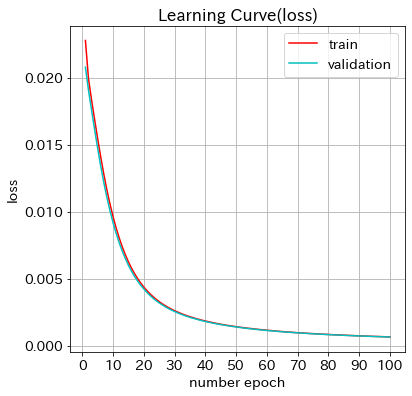

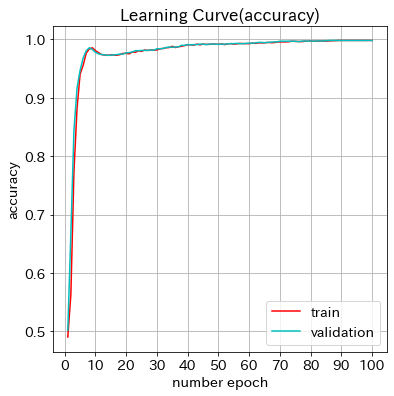

In [23]:
# 評価
evaluate_history(history)

# これはxの絶対値をとったもの

In [22]:
%%time
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.02277 acc: 0.49042 val_loss: 0.02078, val_acc: 0.50208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.01991 acc: 0.56333 val_loss: 0.01906, val_acc: 0.66833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.01833 acc: 0.77333 val_loss: 0.01756, val_acc: 0.84375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.01686 acc: 0.88167 val_loss: 0.01611, val_acc: 0.91667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.01542 acc: 0.94042 val_loss: 0.01470, val_acc: 0.94708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.01405 acc: 0.95583 val_loss: 0.01337, val_acc: 0.96833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.01277 acc: 0.97667 val_loss: 0.01215, val_acc: 0.98083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.01160 acc: 0.98375 val_loss: 0.01104, val_acc: 0.98583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.01056 acc: 0.98583 val_loss: 0.01005, val_acc: 0.98292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.00962 acc: 0.98083 val_loss: 0.00916, val_acc: 0.97792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.00878 acc: 0.97750 val_loss: 0.00837, val_acc: 0.97542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.00803 acc: 0.97417 val_loss: 0.00767, val_acc: 0.97417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.00736 acc: 0.97333 val_loss: 0.00704, val_acc: 0.97375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.00677 acc: 0.97292 val_loss: 0.00649, val_acc: 0.97292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.00624 acc: 0.97375 val_loss: 0.00599, val_acc: 0.97292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.00578 acc: 0.97333 val_loss: 0.00555, val_acc: 0.97375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.00536 acc: 0.97292 val_loss: 0.00516, val_acc: 0.97417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.00500 acc: 0.97417 val_loss: 0.00481, val_acc: 0.97500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.00467 acc: 0.97625 val_loss: 0.00450, val_acc: 0.97500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.00436 acc: 0.97625 val_loss: 0.00423, val_acc: 0.97708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.00411 acc: 0.97542 val_loss: 0.00398, val_acc: 0.97750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.00387 acc: 0.97875 val_loss: 0.00375, val_acc: 0.97875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.00365 acc: 0.97792 val_loss: 0.00354, val_acc: 0.98083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.00346 acc: 0.98083 val_loss: 0.00336, val_acc: 0.98083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.00328 acc: 0.97958 val_loss: 0.00319, val_acc: 0.98125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.00312 acc: 0.98208 val_loss: 0.00304, val_acc: 0.98125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.00298 acc: 0.98125 val_loss: 0.00290, val_acc: 0.98125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.00284 acc: 0.98208 val_loss: 0.00277, val_acc: 0.98208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.00272 acc: 0.98167 val_loss: 0.00265, val_acc: 0.98167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.00260 acc: 0.98208 val_loss: 0.00254, val_acc: 0.98417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.00251 acc: 0.98417 val_loss: 0.00245, val_acc: 0.98417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.00241 acc: 0.98458 val_loss: 0.00235, val_acc: 0.98458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.00232 acc: 0.98583 val_loss: 0.00226, val_acc: 0.98625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.00223 acc: 0.98625 val_loss: 0.00218, val_acc: 0.98708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.00216 acc: 0.98833 val_loss: 0.00211, val_acc: 0.98667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.00209 acc: 0.98625 val_loss: 0.00204, val_acc: 0.98708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.00201 acc: 0.98750 val_loss: 0.00199, val_acc: 0.98750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.00196 acc: 0.98833 val_loss: 0.00191, val_acc: 0.99000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.00189 acc: 0.98958 val_loss: 0.00186, val_acc: 0.99000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.00184 acc: 0.99083 val_loss: 0.00180, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.00179 acc: 0.99083 val_loss: 0.00175, val_acc: 0.99083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.00174 acc: 0.99042 val_loss: 0.00170, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.00169 acc: 0.99208 val_loss: 0.00165, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.00164 acc: 0.99083 val_loss: 0.00161, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.00160 acc: 0.99208 val_loss: 0.00157, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.00156 acc: 0.99167 val_loss: 0.00154, val_acc: 0.99125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.00152 acc: 0.99167 val_loss: 0.00149, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.00148 acc: 0.99208 val_loss: 0.00146, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.00145 acc: 0.99208 val_loss: 0.00142, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.00141 acc: 0.99167 val_loss: 0.00140, val_acc: 0.99167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.00138 acc: 0.99250 val_loss: 0.00136, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.00135 acc: 0.99125 val_loss: 0.00133, val_acc: 0.99208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.00133 acc: 0.99250 val_loss: 0.00130, val_acc: 0.99250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.00129 acc: 0.99292 val_loss: 0.00128, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.00127 acc: 0.99208 val_loss: 0.00125, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.00125 acc: 0.99250 val_loss: 0.00123, val_acc: 0.99333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.00122 acc: 0.99333 val_loss: 0.00120, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.00120 acc: 0.99292 val_loss: 0.00118, val_acc: 0.99292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.00117 acc: 0.99292 val_loss: 0.00115, val_acc: 0.99333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.00115 acc: 0.99292 val_loss: 0.00113, val_acc: 0.99375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.00113 acc: 0.99375 val_loss: 0.00111, val_acc: 0.99375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.00111 acc: 0.99333 val_loss: 0.00109, val_acc: 0.99417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.00109 acc: 0.99417 val_loss: 0.00108, val_acc: 0.99500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.00107 acc: 0.99417 val_loss: 0.00105, val_acc: 0.99500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.00105 acc: 0.99417 val_loss: 0.00103, val_acc: 0.99458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.00103 acc: 0.99500 val_loss: 0.00102, val_acc: 0.99500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.00101 acc: 0.99458 val_loss: 0.00100, val_acc: 0.99542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.00100 acc: 0.99458 val_loss: 0.00098, val_acc: 0.99583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.00098 acc: 0.99542 val_loss: 0.00097, val_acc: 0.99583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.00096 acc: 0.99583 val_loss: 0.00096, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.00095 acc: 0.99583 val_loss: 0.00094, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.00094 acc: 0.99583 val_loss: 0.00092, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.00092 acc: 0.99625 val_loss: 0.00091, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.00091 acc: 0.99708 val_loss: 0.00090, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.00090 acc: 0.99667 val_loss: 0.00088, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.00088 acc: 0.99667 val_loss: 0.00087, val_acc: 0.99625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.00087 acc: 0.99625 val_loss: 0.00086, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.00086 acc: 0.99708 val_loss: 0.00085, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.00085 acc: 0.99708 val_loss: 0.00083, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.00083 acc: 0.99750 val_loss: 0.00082, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.00082 acc: 0.99708 val_loss: 0.00081, val_acc: 0.99708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.00081 acc: 0.99708 val_loss: 0.00080, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.00080 acc: 0.99750 val_loss: 0.00079, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.00079 acc: 0.99750 val_loss: 0.00078, val_acc: 0.99750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.00078 acc: 0.99708 val_loss: 0.00077, val_acc: 0.99792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.00077 acc: 0.99750 val_loss: 0.00076, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.00076 acc: 0.99792 val_loss: 0.00075, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.00075 acc: 0.99792 val_loss: 0.00074, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.00074 acc: 0.99833 val_loss: 0.00073, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.00073 acc: 0.99833 val_loss: 0.00073, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.00072 acc: 0.99833 val_loss: 0.00071, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.00071 acc: 0.99833 val_loss: 0.00071, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.00071 acc: 0.99833 val_loss: 0.00070, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.00070 acc: 0.99833 val_loss: 0.00069, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.00069 acc: 0.99833 val_loss: 0.00068, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.00068 acc: 0.99833 val_loss: 0.00067, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.00067 acc: 0.99833 val_loss: 0.00067, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.00067 acc: 0.99833 val_loss: 0.00066, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.00066 acc: 0.99833 val_loss: 0.00065, val_acc: 0.99833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.00065 acc: 0.99833 val_loss: 0.00065, val_acc: 0.99833
CPU times: user 58min 38s, sys: 10min 34s, total: 1h 9min 13s
Wall time: 2min 9s


In [25]:
# Evaluate the model
from torch.autograd import Variable
test_var = Variable(torch.FloatTensor(x_test), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
values, labels = torch.max(result, 1)
num_right = np.sum(labels.data.numpy() == y_test)
print('Accuracy {:.2f}'.format(num_right / len(y_test)))

Accuracy 0.99
